# Introduction
This paper looks at the Airbnb Listing in New Yor City Dataset and aims to build a model that can accurately predict the price of renting a property based in NYC based on its features. The dataset contains several variables describing the owner (Host Id, Host Since) and the property like Neighbourhood and Zipcode location, Property type (apartment or house), room type, beds, reviews, price. Using these variables a couple of patterns are identified, analyzed and interpreted. The last step was to run a machine learning model (XGBoost) to predict the rental price of the properties.

# 1. Understanding the Data
The first step undertaken was understanding the data. From the dataset, the following important information about the dataset was noted:
* The dataset describes the offered property with 12 variables plus the Price. 
* There are 30478 observations.

# 2. Loading in the Data
The next step in the process was loading in the dataset.

In [194]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

all_data = pd.read_excel("../input/airbnb.xlsx")
all_data

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaT,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaT,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaT,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,2008-06-26,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0
5,1039,2008-07-25,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,100.0,Entire home/apt,11222.0,1.0,1,4,149,100.0
6,1783,2008-08-12,Amazing Also,Manhattan,Apartment,100.0,Entire home/apt,10004.0,1.0,1,9,250,100.0
7,2078,2008-08-15,"Colorful, quiet, & near the subway!",Brooklyn,Apartment,90.0,Private room,11201.0,1.0,1,80,90,94.0
8,2339,2008-08-20,East Village Cocoon: 2 Bedroom Flat,Manhattan,Apartment,90.0,Entire home/apt,10009.0,2.0,1,95,270,90.0
9,2339,2008-08-20,Lovely 2 Bedroom East Village Nest,Manhattan,Apartment,95.0,Entire home/apt,10009.0,2.0,1,23,290,96.0


In [ ]:
all_data.info()

In [ ]:
all_data.describe()

# 3. Exploring the Data

In this step exploration of data was undertaken. There were three goals of this exploration:
1. Search for fields/column with missing values, NAs, blanks and so on.
2. Observe any indentifiable patterns or correlations within the dataset
3. Understand the structure of the dataset - are there fields numeric/categorical/mixed.

The following were the findings of the initial data assessment:
* There are 8 numeric, 1 datetime, 4 categorical fields
* There is a field, *Number of Records*, which gives almost no information about the changes in the Price
* Two fields, *Review Scores Rating (bin)* and *Review Scores Rating*, are almost the same in values (corellation about 1.0). It seems that these fields contain average score rating of each of the properties, which were conducted using a slightly different methods. The results, however, is almost identical.
* There are some fields/columns containing up to 30% of NAs and/or blanks. In Review Scores Rating some of the scores might be missing, because there was not any rating submitted for this property (Number of Reviews = 0). In that case the missing value should be None. There are also cases, 1.7% of all observations, with Number of Reviews higher than 0 for which Review Scores Rating is missing. These fields were removed. Beds, Zipcode, Host Sicne, Property Type obervations with missing values were also removed from dataset because it is less than 1% of the all observations.
* Most of the properties are Apartments (89%), then Houses (7%). Nearly half of obervations, 56%, consists of entire homes/apartments, and 41% is the offer of a private room. The rest, 3%, are shared rooms. As it comes to Neighbourhood Brooklyn and Manhattan are the most popular - 38% and 53% correspondingly.
* Most of the Hosts (85.7%) rent only one property, but the mean is equal to 1.25. There is one Host renting 32 properties. 95% of Hosts rent up to 2 properties, 97.7% up to 3 and 99.9 up to 10. Only 24 Hosts rent more than 10
* Only one field *Beds* has a moderate correlation value with the Price. It seems logical, because the more beds in the room/property, the more people can stay and price can (but do not have to) be higher.

**Handling missing values**

In [185]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum() / all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.DataFrame(
                            {'Total' : total[total > 0],
                             'Missing Ratio': percent[percent > 0]
                            }
                            )
print("Missing values in the dataset")
print(missing_data)

total = all_data[all_data['Number Of Reviews'] > 0].isnull().sum()
percent = (total / all_data.isnull().count())
missing_data = pd.DataFrame(
                            {'Total' : total[total > 0],
                             'Missing Ratio': percent[percent > 0]
                            }
                            ).sort_values(by='Total', ascending=False)
print("\n Missing values for fields with Number of Reviews > 0")
print(missing_data)

Missing values in the dataset
                            Total  Missing Ratio
Review Scores Rating         8323       0.273082
Review Scores Rating (bin)   8323       0.273082
Zipcode                       134       0.004397
Beds                           85       0.002789
Property Type                   3       0.000098
Host Since                      3       0.000098

 Missing values for fields with Number of Reviews > 0
                            Total  Missing Ratio
Review Scores Rating (bin)    509       0.016701
Review Scores Rating          509       0.016701
Zipcode                       104       0.003412
Beds                           46       0.001509
Host Since                      2       0.000066
Property Type                   2       0.000066


In [195]:
# droping Review Scores Rating (bin) column which gives almost same information like its 'brother'
all_data = all_data.drop('Review Scores Rating (bin)', axis = 1)

# droping 509 observations which have at least 1 review but missing score rating
index_to_drop = all_data[(all_data['Number Of Reviews'] > 0) & (all_data['Review Scores Rating'].isnull())].index
all_data = all_data.drop(index_to_drop)

# droping observations for which Beds, Zipcode, Host Since and Property Types are NA
index_to_drop = all_data[all_data['Beds'].isnull() | all_data['Zipcode'].isnull() | all_data['Host Since'].isnull() | all_data['Property Type'].isnull() ].index
all_data = all_data.drop(index_to_drop)

# fill the rest of missing Review Scores Rating observations with None value
all_data['Review Scores Rating'] = all_data['Review Scores Rating'].fillna("None")

In [196]:
#Check remaining missing values if any 
total = all_data.isnull().sum()
total[total > 0]

Series([], dtype: int64)

**Prepare train and test datasets**

The *Train* part was used to analyse the dataset, feature engineering and training the model. The *Test* part was used to validate the model.

In [197]:
from sklearn.model_selection import train_test_split

y = all_data.Price
X_train, X_test, y_train, y_test = train_test_split(all_data,y,test_size=0.2)

X_test.drop(['Price'], axis = 1, inplace = True)

# temporary joining together X_train and X_test for EDA analysis
print(X_train.shape)
print(X_test.shape)

#ntrain = X_train.shape[0]
#ntest = X_test.shape[0]

#all_data = pd.concat((X_train, X_test), sort = False)

(23802, 12)
(5951, 11)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Correlation analysis**

There were a few findings from the correlation heatmap:
* As can be seen from graph *Numer of Records* is a non-informative variable (it was also seen with the previous result of describe() funtion). We can drop the whole column from the dataset. 
* Only one field *Beds* has some correlation value with the Price. It seems logical, because the more beds in the room/property, the more people can stay and price can (but do not have to) be higher.

Pairplot analysis provided following findings:
* Outliers - there is one outlier with the price 10000
* With the higher number of reviews, the lower is the price of the property
* There is no visible correlation between the price and the number of beds

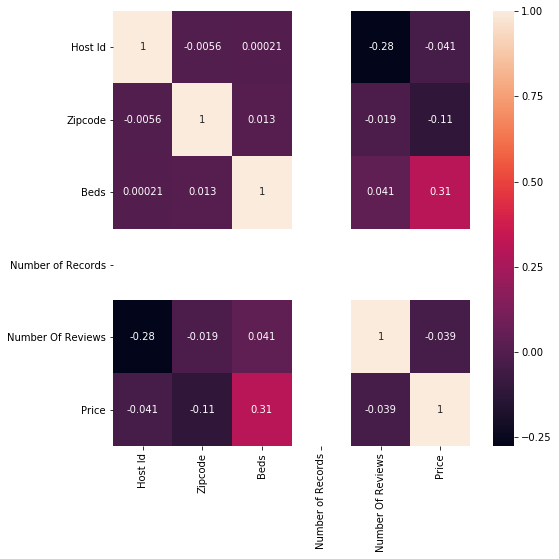

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation matrix is run only on X_train part which has known Price field.
correlation_matrix = X_train.corr()
plt.subplots(figsize = (8,8))
sns.heatmap(correlation_matrix, annot = True)

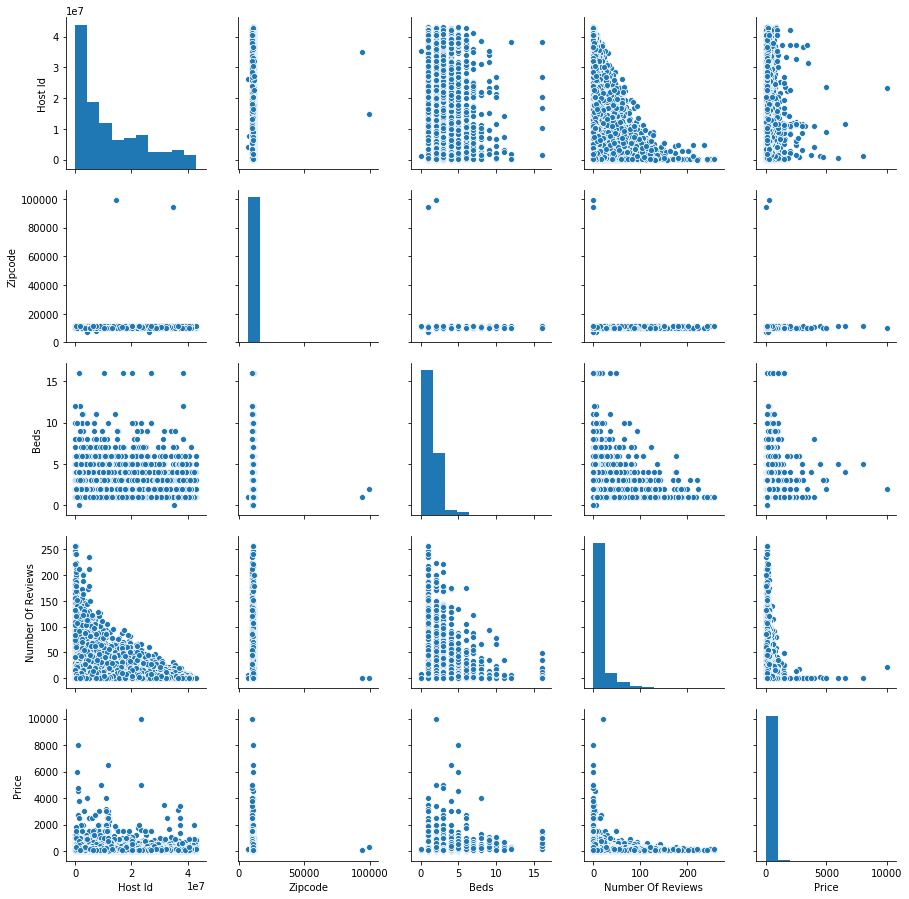

In [200]:
# dropping Number of Records from X_train and X_test
X_train = X_train.drop(['Number of Records'], axis = 1)
X_test = X_test.drop(['Number of Records'], axis = 1)

# plotting useful graphs for analytics
sns.pairplot(X_train, height = 2.5)
plt.show();

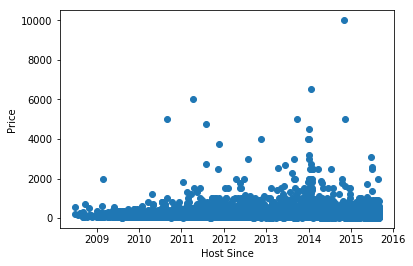

In [191]:
fig, ax = plt.subplots()
ax.plot_date(x = X_train['Host Since'], y = X_train['Price'])
plt.ylabel('Price')
plt.xlabel('Host Since')
plt.show()

**Handling outliers**

In [201]:
# dropping observation with the Price equal to 10000
X_train = X_train.drop(X_train[X_train['Price'] == 10000].index)
X_train = X_train.drop(X_train[X_train['Zipcode'] > 50000].index)


## Target variable
Analysis of the Price
* The average price of rental is 163 dollars, median 125 dollars. 
* The price plot skewness is very high which means that there are a couple of highly valued properties that behave like outliers - 99,5% of observations are between 0-1000 dolars, while 132 observations are between 1000-10000 dollars. 
* Out of extremly expensive rentals, 86 are Apartments in Manhattan with the average rating at 97,3points (lowest 76points). There is one host with id 37155810 who has 5 luxury properties, but all of them without Rating score.

Because of high skewness observations with the price higher than 1000 dollars were dropped. Next, the log transformation was applied to the Price variable.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 163.90 and sigma = 192.18



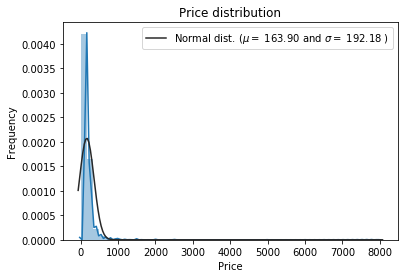

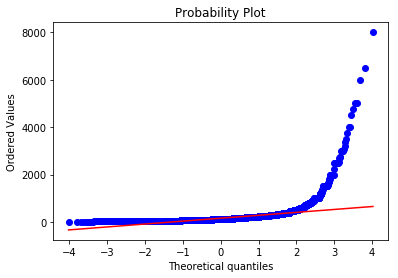

In [202]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(X_train['Price'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X_train['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X_train['Price'], plot=plt)
plt.show()

In [203]:
# log transformation usually works well with skewness
X_train = X_train.drop(X_train[X_train['Price'] > 1000].index)
X_train['Price'] = np.log1p(X_train['Price'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 4.86 and sigma = 0.60



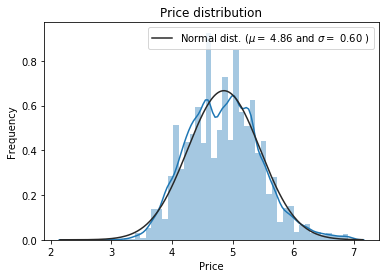

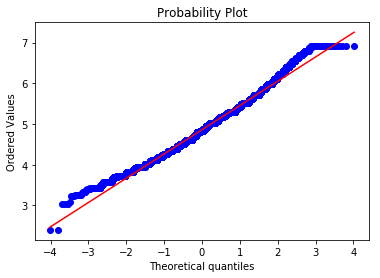

In [204]:
sns.distplot(X_train['Price'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X_train['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X_train['Price'], plot=plt)
plt.show()

**Preparing data for training**

In [205]:
# moving Price column (after previous transformations) to separate variable
y_train = X_train['Price']
X_train = X_train.drop(['Price'], axis = 1)

# transform datatime type of Host Since to integer 
X_train['date_delta'] = (X_train['Host Since'] - X_train['Host Since'].min())  / np.timedelta64(1,'D')
X_train = X_train.drop(["Host Since"], axis = 1)

X_test['date_delta'] = (X_test['Host Since'] - X_test['Host Since'].min())  / np.timedelta64(1,'D')
X_test = X_test.drop(["Host Since"], axis = 1)

# check which columns are categorical
X_train.columns[X_train.dtypes == "object"]

# identify and create distinct values in categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X_train.columns[X_train.dtypes == "object"]:
    X_train[col] = X_train[col].factorize()[0]
    
# identify and create distinct values in categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X_test.columns[X_test.dtypes == "object"]:
    X_test[col] = X_test[col].factorize()[0]

# 3. Machine learning

In [206]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error

train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(val_x, val_y)], verbose=False)

# check the accuracy of the full train dataset
accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_log_error")
print("Accuracy of train data:", np.sqrt(-accuracy.mean()))

Accuracy of train data: 0.05838369312723391


In [207]:
pd.DataFrame(
                            {'Prediction' : model.predict(train_x),
                             'True values': train_y
                            }
                            )

,Prediction,True values
10977,5.151904,4.983607
14168,5.054110,4.941642
16346,4.800026,4.564348
8945,4.837497,5.393628
29780,4.694871,5.525453
24432,5.271154,4.394449
2899,4.955543,4.454347
5476,4.436595,4.369448
15116,5.334435,5.707110
13798,5.342083,5.303305
